###This IPython Notebook is for performing a fit and generating a figure of the spectrum of sample VG03, in the region with ~4.5% fill factor

The filename of the figure is **VG03_f045.pdf**.

Author: Michael Gully-Santiago, `gully@astro.as.utexas.edu`

Date: January 13, 2015

In [2]:
%pylab inline
import emcee
import triangle
import pandas as pd
import seaborn as sns
from astroML.decorators import pickle_results

Populating the interactive namespace from numpy and matplotlib


In [3]:
sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 2.5})
sns.set(style="ticks")

Read in the data.  We want "VG03_pos1"

In [4]:
df = pd.read_csv('../data/cln_20130218_cary5000.csv', index_col=0)
df = df[df.index > 1250.0]

Import all the local models, saved locally as `etalon.py`.  See the paper for derivations of these equations.

In [5]:
from etalon import *
np.random.seed(78704) #My old zip code

In [6]:
# Introduce the Real data
x = df.index.values
N = len(x)
# Define T_DSP for the model
T_DSP = T_gap_Si(x, 0.0)
n1 = sellmeier_Si(x)

# Define uncertainty
yerr = 0.0002*np.ones(N)
iid_cov = np.diag(yerr ** 2)

# Select the spectrum of interest
# Normalize the spectrum by measured DSP Si wafer.
y = df.VG03_pos2/df.VG06

Define the likelihood.

In [7]:
def lnlike(d, f, lna, lns):
    a, s = np.exp(lna), np.exp(lns)
    off_diag_terms = a**2 * np.exp(-0.5 * (x[:, None] - x[None, :])**2 / s**2)
    C = iid_cov + off_diag_terms
    sgn, logdet = np.linalg.slogdet(C)
    if sgn <= 0:
        return -np.inf
    r = y - T_gap_Si_withFF_fast(x, d, f, n1)/T_DSP
    return -0.5 * (np.dot(r, np.linalg.solve(C, r)) + logdet)

Define the prior.

In [8]:
def lnprior(d, f, lna, lns):
    if not (4050 < d < 4200 and 0.0 < f < 0.5 and -12 < lna < -2 and 0 < lns < 10):
        return -np.inf
    return 0.0

Combine likelihood and prior to obtain the posterior.

In [9]:
def lnprob(p):
    lp = lnprior(*p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(*p)

Set up `emcee`.

In [10]:
@pickle_results('SiGaps_08_VG03_f045-sampler.pkl')
def hammer_time(ndim, nwalkers, d_Guess, f_Guess, a_Guess, s_Guess, nburnins, ntrials):
    
    # Initialize the walkers
    p0 = np.array([d_Guess, f_Guess, np.log(a_Guess), np.log(s_Guess)])
    pos = [p0 + 1.0e-2*p0 * np.random.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    
    pos, lp, state = sampler.run_mcmc(pos, nburnins)
    sampler.reset()
    pos, lp, state = sampler.run_mcmc(pos, ntrials)
    return sampler

Set up the initial conditions.

In [11]:
np.random.seed(78704)
ndim, nwalkers = 4, 32
d_Guess = 4120.0
f_Guess = 0.045
a_Guess = 0.0016
s_Guess = 25.0
nburnins = 300
ntrials = 1000

Run the burn-in phase.  Run the full MCMC. Pickle the results.

In [12]:
sampler = hammer_time(ndim, nwalkers, d_Guess, f_Guess, a_Guess, s_Guess, nburnins, ntrials)

@pickle_results: computing results and saving to 'SiGaps_08_VG03_f045-sampler.pkl'


Linearize $a$ and $s$ for easy inspection of the values.

In [13]:
chain = sampler.chain
samples_lin = copy(sampler.flatchain)
samples_lin[:, 2:] = np.exp(samples_lin[:, 2:])

Inspect the chain.

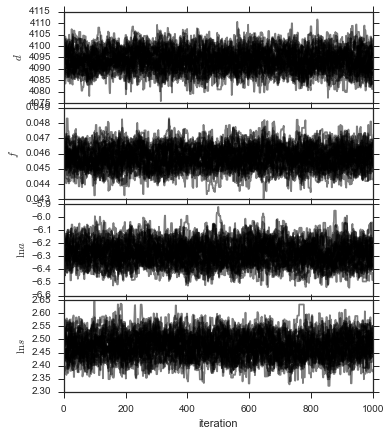

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(5, 6), sharex=True)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.96, top=0.98,
                    wspace=0.0, hspace=0.05)
[a.plot(np.arange(chain.shape[1]), chain[:, :, i].T, "k", alpha=0.5)
 for i, a in enumerate(axes)]
[a.set_ylabel("${0}$".format(l)) for a, l in zip(axes, ["d", "f", "\ln a", "\ln s"])]
axes[-1].set_xlim(0, chain.shape[1])
axes[-1].set_xlabel("iteration");

Make a triangle corner plot.

Quantiles:
[(0.16, 4089.5832276737651), (0.84, 4098.2914836921846)]
Quantiles:
[(0.16, 0.045107373191580022), (0.84, 0.046419474652892354)]
Quantiles:
[(0.16, 0.0017329038120982318), (0.84, 0.0020407225903503303)]
Quantiles:
[(0.16, 11.37520415783132), (0.84, 12.382196837791241)]


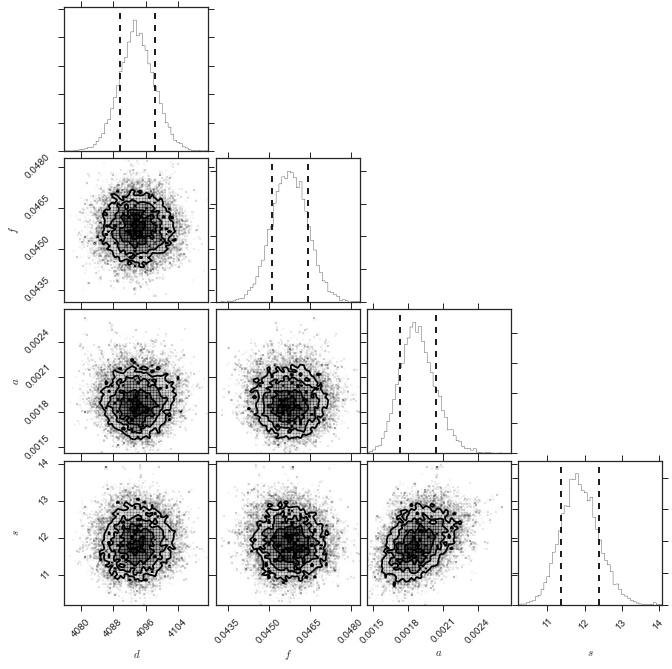

In [15]:
fig = triangle.corner(samples_lin, 
                      labels=map("${0}$".format, ["d", "f", "a", "s"]), 
                      quantiles=[0.16, 0.84])

Quantiles:
[(0.16, 4089.5832276737651), (0.84, 4098.2914836921846)]
Quantiles:
[(0.16, 0.045107373191580022), (0.84, 0.046419474652892354)]


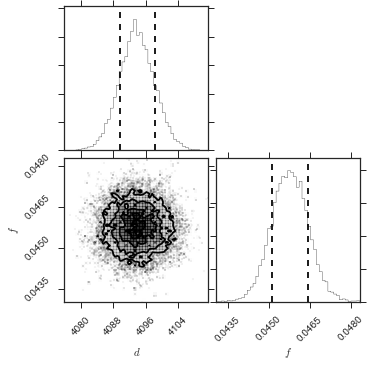

In [16]:
fig = triangle.corner(samples_lin[:,0:2], 
                      labels=map("${0}$".format, ["d", "f"]), 
                      quantiles=[0.16, 0.84])
plt.savefig("VG03p2_corner.pdf")

Calculate confidence intervals.

In [17]:
d_mcmc, f_mcmc, a_mcmc, s_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples_lin, [16, 50, 84],
                                                axis=0)))
d_mcmc, f_mcmc, a_mcmc, s_mcmc

((4093.8052083810621, 4.4862753111224265, 4.221980707297007),
 (0.045763037618155915, 0.00065643703473643872, 0.00065566442657589291),
 (0.001874827095800039, 0.00016589549455029123, 0.00014192328370180723),
 (11.856952712671731, 0.52524412511951013, 0.48174855484041146))

In [18]:
print "{:.0f}^{{+{:.0f}}}_{{-{:.0f}}}".format(*d_mcmc)
print "{:.3f}^{{+{:.3f}}}_{{-{:.3f}}}".format(*f_mcmc)

4094^{+4}_{-4}
0.046^{+0.001}_{-0.001}


Overlay draws from the Gaussian Process.

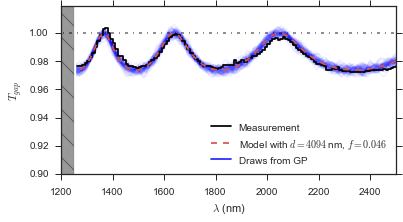

In [19]:
plt.figure(figsize=(6,3))

for d, f, a, s in samples_lin[np.random.randint(len(samples_lin), size=60)]:
    off_diag_terms = a**2 * np.exp(-0.5 * (x[:, None] - x[None, :])**2 / s**2)
    C = iid_cov + off_diag_terms
    fit = T_gap_Si_withFF_fast(x, d, f, n1)/T_DSP
    vec = np.random.multivariate_normal(fit, C)
    plt.plot(x, vec,"-b", alpha=0.06)

plt.step(x, y,color="k", label='Measurement')
fit = T_gap_Si_withFF_fast(x, d_mcmc[0], f_mcmc[0], n1)/T_DSP
fit_label = 'Model with $d={:.0f}$ nm, $f={:.3f}$'.format(d_mcmc[0], f_mcmc[0])
plt.plot(x, fit, '--', color=sns.xkcd_rgb["pale red"], alpha=1.0, label=fit_label)
plt.plot([-10, -9], [-10, -9],"-b", alpha=0.85, label='Draws from GP')
plt.plot([0, 5000], [1.0, 1.0], '-.k', alpha=0.5)
plt.fill_between([1200, 1250], 2.0, 0.0, hatch='\\', alpha=0.4, color='k', label='Si absorption cutoff')

plt.xlabel('$\lambda$ (nm)');
plt.ylabel('$T_{gap}$');
plt.xlim(1200, 2501);
plt.ylim(0.9, 1.019);
plt.legend(loc='lower right')
plt.savefig("VG03_f045.pdf",  bbox_inches='tight')

Figure for the talk

In [20]:
sns.set_context('talk', font_scale=1.3)

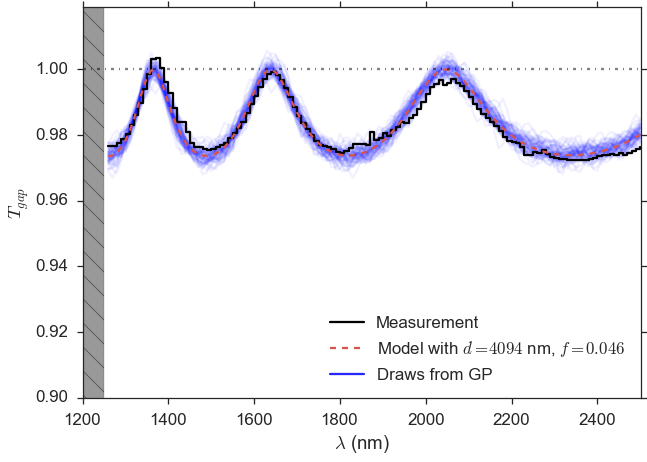

In [23]:
plt.figure(figsize=(10,7))

for d, f, a, s in samples_lin[np.random.randint(len(samples_lin), size=60)]:
    off_diag_terms = a**2 * np.exp(-0.5 * (x[:, None] - x[None, :])**2 / s**2)
    C = iid_cov + off_diag_terms
    fit = T_gap_Si_withFF_fast(x, d, f, n1)/T_DSP
    vec = np.random.multivariate_normal(fit, C)
    plt.plot(x, vec,"-b", alpha=0.06)

plt.step(x, y,color="k", label='Measurement')
fit = T_gap_Si_withFF_fast(x, d_mcmc[0], f_mcmc[0], n1)/T_DSP
fit_label = 'Model with $d={:.0f}$ nm, $f={:.3f}$'.format(d_mcmc[0], f_mcmc[0])
plt.plot(x, fit, '--', color=sns.xkcd_rgb["pale red"], alpha=1.0, label=fit_label)
plt.plot([-10, -9], [-10, -9],"-b", alpha=0.85, label='Draws from GP')
plt.plot([0, 5000], [1.0, 1.0], '-.k', alpha=0.5)
plt.fill_between([1200, 1250], 2.0, 0.0, hatch='\\', alpha=0.4, color='k', label='Si absorption cutoff')

plt.xlabel('$\lambda$ (nm)');
plt.ylabel('$T_{gap}$');
plt.xlim(1200, 2501);
plt.ylim(0.9, 1.019);
plt.legend(loc='lower right')
plt.savefig("VG03_f045_GP.pdf",  bbox_inches='tight')

The end.